<a href="https://colab.research.google.com/github/TLG229/DS-Unit-2-Kaggle-Challenge/blob/master/Copy_of_224_Tanzanian_Waterpump_Pred_precision_recall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [ ]:
#importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

#Data Wrangling


In [ ]:
# WRANGLE FUNCTION

def wrangle(df):
  # Make a copy
  df = df.copy()

  # Drop repeat rows (observations)
  df.drop_duplicates(inplace=True)

  # Drop repeat columns (features)
  df.drop(columns=['quantity_group', 'extraction_type_group'], inplace=True)

  # Drop constant features
  df.drop(columns=['recorded_by'], inplace=True)

  # feature engineering
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df['date_recorded'] = df['date_recorded'].dt.year

  # drop datetime column
  df.drop(columns='date_recorded', inplace=True)

  # high-cardinality
  drop_cols = [col for col in df.select_dtypes('object').columns
               if df[col].nunique() > 100]
  df.drop(columns=drop_cols, inplace=True)

  # Drop features with lots of NaN values
  df.dropna(axis=1, thresh=len(df)*0.8, inplace=True)

  return df

# Import and clean TRAINING dataset
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv',
                          parse_dates=['date_recorded'],
                          na_values=[0, -2.000000e-08]), 
              pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

df = wrangle(df)

# Import and clean TEST dataset
X_test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv',
            parse_dates=['date_recorded'],
            na_values=[0, -2.000000e-08],
            index_col='id')

X_test = wrangle(X_test)

#Splitting Data - not necessary when using KFold Validation

In [ ]:
#Accuracy as a baseline

print('Baseline Accuracy:', df['status_group'].value_counts(normalize=True).max())

Baseline Accuracy: 0.5430487003689166


#Building Model

In [ ]:
X_train = df.drop(['status_group'], axis=1)
y_train = df['status_group']

In [ ]:
#making a pipeline for random forest model using RandomForestClassifier

rf = make_pipeline(OrdinalEncoder(),
                   SimpleImputer(),
                   RandomForestClassifier(n_estimators=100, max_depth=20, max_samples=0.7))
                  

In [ ]:
#training model

rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                   

In [ ]:
#transforming data sets from 3 categories to 2 either functional or needs repair

train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [ ]:
#needs repair = 1 , doesn't need repair = 0
train['status_group'].replace({'functional':0,
                               'non functional':1,
                               'functional needs repair':1}).head()



id
69572    0
8776     0
34310    0
67743    1
19728    0
Name: status_group, dtype: int64

In [ ]:
#Wrangle Data

if 'status_group' in df:
  #creating binary target
  df['needs_repair'] = df['status_group'].replace({'functional': 0,
                                               'non functional':1,
                                               'functional needs repair': 1})




In [ ]:
df['status_group']

id
69572.0        functional
8776.0         functional
34310.0        functional
67743.0    non functional
19728.0        functional
                ...      
60739.0        functional
27263.0        functional
37057.0        functional
31282.0        functional
26348.0        functional
Name: status_group, Length: 59363, dtype: object

In [ ]:
#creating new binary target

X=df.drop(['needs_repair', 'status_group'], axis=1)
y = df['needs_repair']

#Splitting Data

#Baseline

In [ ]:
y_train.value_counts(normalize=True).max()

0.5441566645609602

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2,random_state=42)

#Building RF Model w/ a pipeline


In [ ]:
model = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, max_depth=20, max_samples=0.7, n_jobs=-1))


In [ ]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                   

#Checking Metrics


In [ ]:
print('Training Accuracy:',model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9183828174352495
Validation Accuracy: 0.8167270277099301


In [ ]:
y_pred = model.predict(X_val)

In [ ]:
accuracy_score(y_val, y_pred)

0.8167270277099301

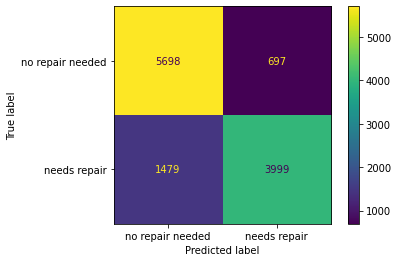

In [ ]:
#Confusion Matrix

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_val, y_val, values_format='.0f',
display_labels = ['no repair needed', 'needs repair'])

In [ ]:
#precision: of all the pumps that werepredicted to need repair, 
#what proportion actually needed repair?  TP/(TP+FP)
print(3999 / (3999+697))


0.8515758091993185


In [ ]:
#recall:of those pumps that neede repair, what proportion were 
#correctly predicted (TP/TP+FN)
print(3999/(3999+1269))

0.7591116173120729


In [ ]:
#using classification report
print(classification_report(y_val, model.predict(X_val),
                            target_names=['no repair needed','needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.79      0.89      0.84      6395
    needs repair       0.85      0.73      0.79      5478

        accuracy                           0.82     11873
       macro avg       0.82      0.81      0.81     11873
    weighted avg       0.82      0.82      0.81     11873



In [ ]:
#Submission
y_pred=model.predict(X_test)

In [ ]:
data = {'id': X_test.index, 'status_group': y_pred}
submission = pd.DataFrame(data)

In [ ]:
submission

,id,status_group
0,50785,1
1,51630,0
2,17168,0
3,45559,1
4,49871,0
...,...,...
14353,39307,1
14354,18990,0
14355,28749,0
14356,33492,0


In [ ]:
submission.to_csv('tanz_wtr_pump_1-21-21-2.csv', index=False)

In [ ]:
from google.colab import files
files.download('tanz_wtr_pump_1-21-21-2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>